The following code is from
[Link](https://github.com/justinbois/rdsolver/blob/master/notebooks/asdm_example.ipynb)

In [97]:
%config Completer.use_jedi = False

In [1]:
import numpy as np
import numba
import scipy.integrate
from matplotlib import pyplot as plt

import rdsolver

In [2]:
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

In [124]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = (32, 32)
L = (50, 50)
t = np.linspace(0, 50000, 500000+1)

# Initial condition and solve
c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)

# Interpolate the solution
#c_interp = rdsolver.viz.interpolate_concs(c)

100%|██████████| 500001/500001 [01:08<00:00, 7307.59it/s]  


#### D[0] = D_a
#### D[1] =  D_s
#### beta[0] = sigma_a
#### beta[1] = sigma_s
#### gamma[0,0] = mu_a
#### gamma[1,1] = mu_s
#### rho_a = f_args[0]
#### rho_s = f_args[1]
#### kappa_a = f_args[2]

> when the kenetic terms are 
<h3><center>$f(a,s) = \rho_a \frac{a^2 s}{1 + \kappa_a a^2} - \mu_a a +\sigma_a$,</center></h3>
<h3><center>$g(a,s) = -\rho_s \frac{a^2 s}{1 + \kappa_a a^2} +\sigma_s$,</center></h3>

> then, their derivatives are

<h3><center>$\frac{\partial f(a,s)}{\partial a} = \rho_a \frac{2 a s}{(1 + \kappa_a a^2)^2} - \mu_a$,</center></h3>
<h3><center>$\frac{\partial f(a,s)}{\partial s} = \rho_a \frac{ a^2}{1 + \kappa_a a^2}$,</center></h3>
<h3><center>$\frac{\partial g(a,s)}{\partial a} = -\rho_s \frac{2 a s}{(1 + \kappa_a a^2)^2}$,</center></h3>
<h3><center>$\frac{\partial g(a,s)}{\partial s} = -\rho_s \frac{ a^2}{1 + \kappa_a a^2}$,</center></h3>


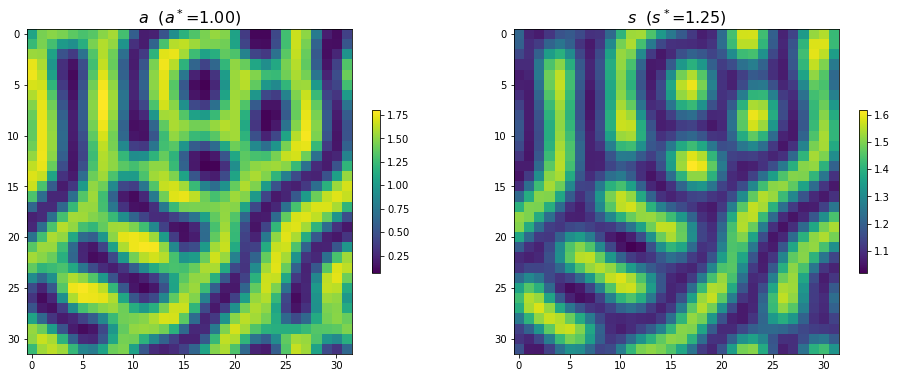

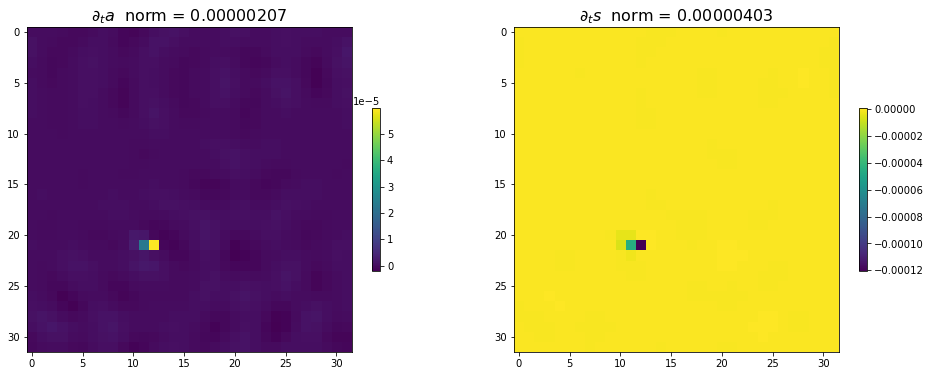

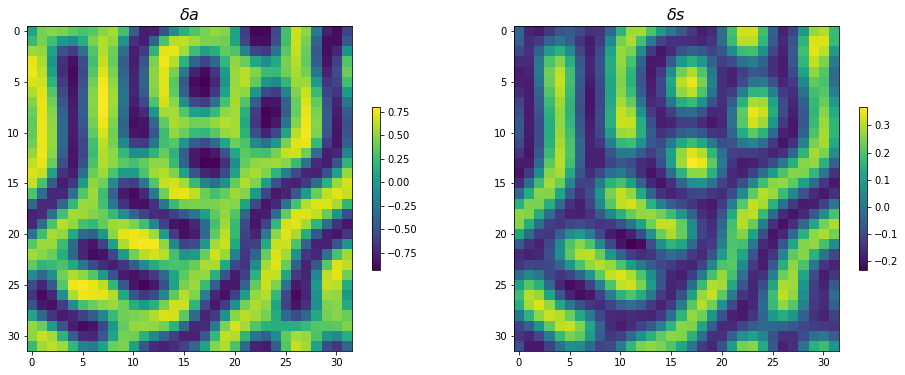

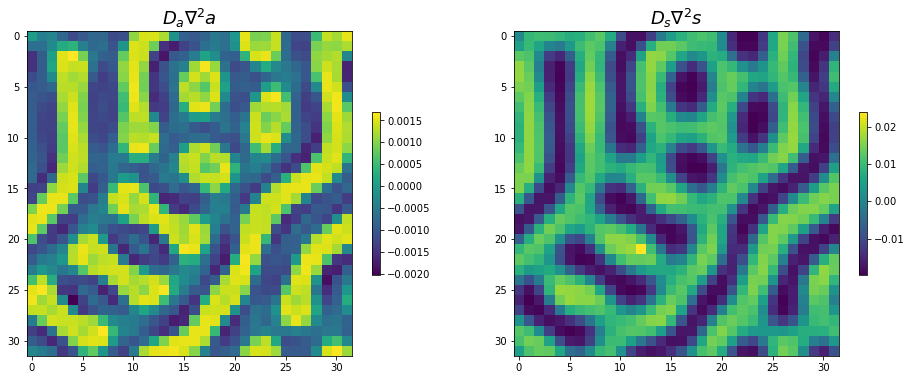

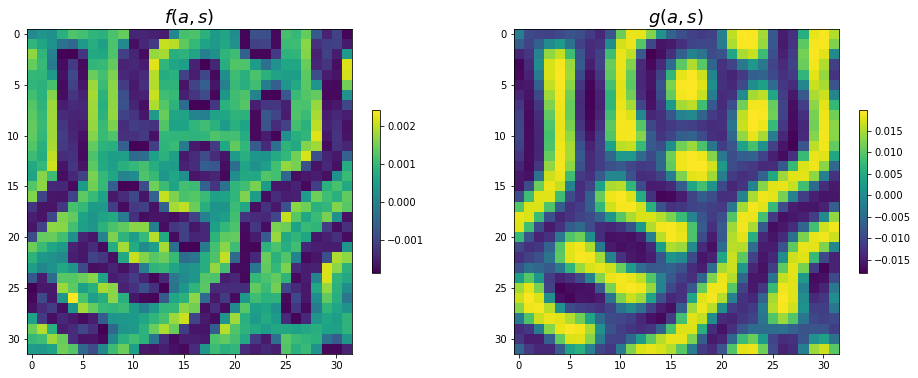

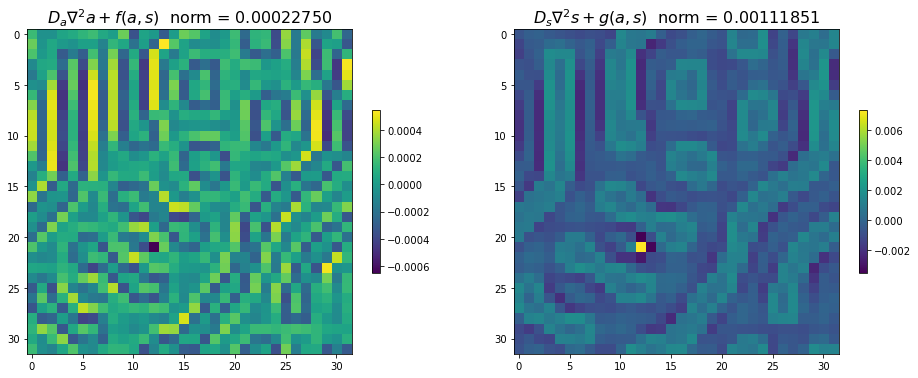

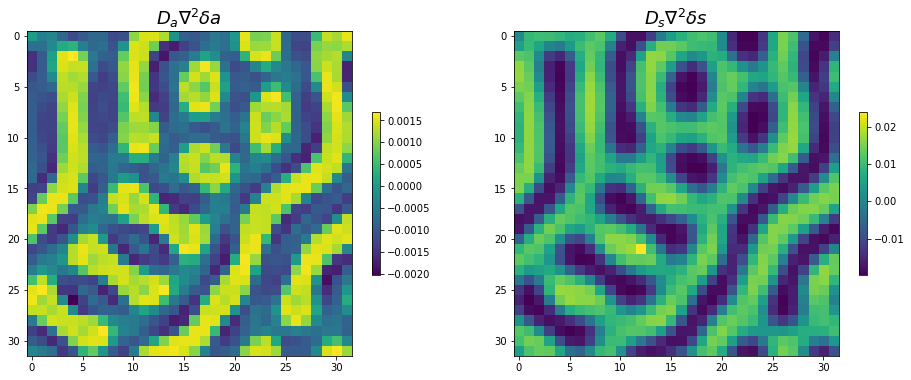

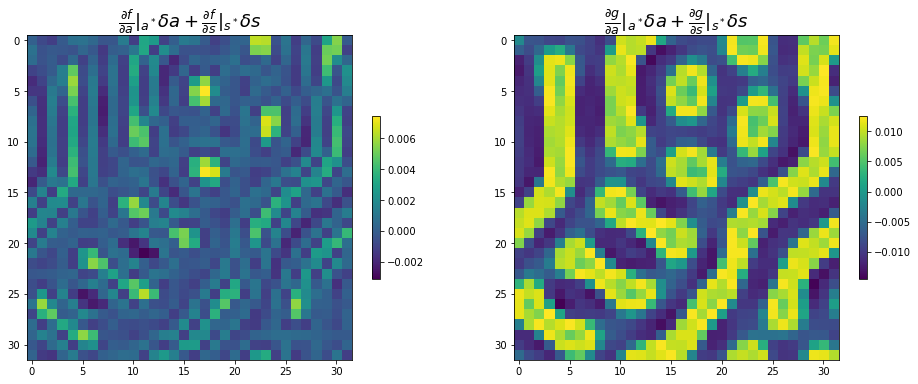

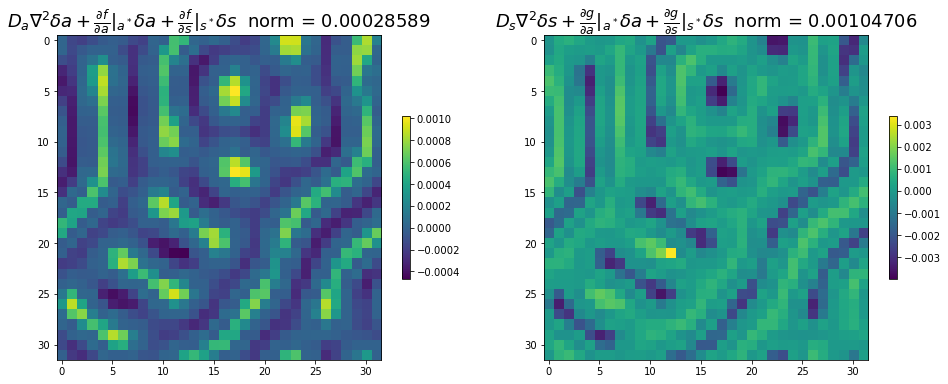

In [125]:
from scipy.ndimage import laplace

D_a = D[0]
D_s = D[1]
sigma_a = beta[0]
sigma_s = beta[1]
mu_a = -gamma[0,0]
mu_s = -gamma[1,1]
rho_a = f_args[0]
rho_s = f_args[1]
kappa_a = f_args[2]

L_1 = L[0]/n[0]
L_2 = L[1]/n[1]

a_star = homo_ss[0]#np.mean(a)
s_star = homo_ss[1]#np.mean(s)

def ff(a,s):
    return rho_a*a*a*s/(1+kappa_a*a*a) - mu_a*a + sigma_a

def gg(a,s):
    return -rho_s*a*a*s/(1+kappa_a*a*a) + sigma_s

def d_f(a,s):    
    d_f_d_a = rho_a*(2*a*s/(1+kappa_a*a*a)**2) - mu_a
    d_f_d_s = rho_a*a*a/(1+kappa_a*a*a)
    return (d_f_d_a, d_f_d_s)

def d_g(a,s):    
    d_g_d_a = -rho_s*(2*a*s/(1+kappa_a*a*a)**2)
    d_g_d_s = -rho_s*a*a/(1+kappa_a*a*a)
    return (d_g_d_a, d_g_d_s)

def linear_f(a, s):
    d_f_d_a, d_f_d_s = d_f(a,s)
    return d_f_d_a*(a-a_star) + d_f_d_s*(s-s_star)

def linear_g(a, s):
    d_g_d_a, d_g_d_s = d_g(a,s)
    return d_g_d_a*(a-a_star) + d_g_d_s*(s-s_star)

def diffusion_term(field, D):
    return D*laplace(field, mode="wrap" )/(L_1*L_2)

def rhs_a(a,s, linear = False):
    diffusion = diffusion_term(a, D_a)
    if linear:
        return (diffusion + linear_f(a, s))/8
    else:
        return diffusion + ff(a,s)
    
def rhs_s(a,s, linear = False):
    diffusion = diffusion_term(s, D_s)
    if linear:
        d_g_d_a, d_g_d_s = d_g(a,s)
        return (diffusion + linear_g(a, s))/4
    else:
        return diffusion + gg(a,s)


def norm(arr):
    return np.sqrt(np.mean(arr*arr))


a = c[0, :,:,-1]
s = c[1, :,:,-1]

d_t_a = (c[0, :,:,-1] - c[0, :,:,-2])#/((t[-1]-t[-2]))
d_t_s = (c[1, :,:,-1] - c[1, :,:,-2])#/((t[-1]-t[-2]))

delta_a = a - a_star
delta_s = s - s_star


a_rhs  = rhs_a(a, s, linear=True)
s_rhs  = rhs_s(a, s, linear=True)


a_full_rhs = rhs_a(a, s, linear=False)
s_full_rhs = rhs_s(a, s, linear=False)




_ = plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(a)
plt.title(r"$a$  " r"($a^*$=" f"{a_star:.2f})" , fontsize=16)
plt.colorbar(shrink=.5)
plt.subplot(122)
plt.imshow(s)
plt.title(r"$s$  " r"($s^*$=" f"{s_star:.2f})", fontsize=16)
plt.colorbar(shrink=.5)
plt.show()

_ = plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(d_t_a)
plt.title(r"$\partial_t a$" 
          f"  norm = {norm(d_t_a):.8f}", fontsize=16)
plt.colorbar(shrink=.5)
plt.subplot(122)
plt.imshow(d_t_s)
plt.title(r"$\partial_t s$" 
          f"  norm = {norm(d_t_s):.8f}", fontsize=16)
plt.colorbar(shrink=.5)
plt.show()

_ = plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(delta_a)
plt.title(r"$\delta a$", fontsize=16)
plt.colorbar(shrink=.5)
plt.subplot(122)
plt.imshow(delta_s)
plt.title(r"$\delta s$", fontsize=16)
plt.colorbar(shrink=.5)
plt.show()

_ = plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(diffusion_term(a, D_a))
plt.title(r"$D_a \nabla^2  a$", fontsize=18)
plt.colorbar(shrink=.5)
plt.subplot(122)
plt.imshow(diffusion_term(s, D_s))
plt.title(r"$D_s \nabla^2 s$", fontsize=18)
plt.colorbar(shrink=.5)
plt.show()



_ = plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(ff(a,s))
plt.title(r"$f(a,s)$", fontsize=18)
plt.colorbar(shrink=.5)
plt.subplot(122)
plt.imshow(gg(a,s))
plt.title(r"$g(a,s)$", fontsize=18)
plt.colorbar(shrink=.5)
plt.show()

_ = plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(a_full_rhs)
plt.title(r"$D_a \nabla^2  a + f(a,s)$"  
          f"  norm = {norm(a_full_rhs):.8f}", fontsize=16)
plt.colorbar(shrink=.5)
plt.subplot(122)
plt.imshow(s_full_rhs)
plt.title(r"$D_s \nabla^2  s + g(a,s)$"  
          f"  norm = {norm(s_full_rhs):.8f}", fontsize=16)
plt.colorbar(shrink=.5)
plt.show()

_ = plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(diffusion_term(a, D_a))
plt.title(r"$D_a \nabla^2 \delta a$", fontsize=18)
plt.colorbar(shrink=.5)
plt.subplot(122)
plt.imshow(diffusion_term(s, D_s))
plt.title(r"$D_s \nabla^2 \delta s$", fontsize=18)
plt.colorbar(shrink=.5)
plt.show()

_ = plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(linear_f(a, s))
plt.title(r"$ \left. \frac{\partial f}{\partial a}\right|_{a^*} \delta a  + \left. \frac{\partial f}{\partial s}\right|_{s^*} \delta s$", fontsize=18)
plt.colorbar(shrink=.5)
plt.subplot(122)
plt.imshow(linear_g(a, s))
plt.title(r"$ \left. \frac{\partial g}{\partial a}\right|_{a^*} \delta a  + \left. \frac{\partial g}{\partial s}\right|_{s^*} \delta s$", fontsize=18)
plt.colorbar(shrink=.5)
plt.show()

_ = plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(a_rhs)
plt.title(r"$D_a \nabla^2 \delta a + \left. \frac{\partial f}{\partial a}\right|_{a^*} \delta a  + \left. \frac{\partial f}{\partial s}\right|_{s^*} \delta s$" 
          f"  norm = {norm(a_rhs):.8f}", fontsize=18)
plt.colorbar(shrink=.5)
plt.subplot(122)
plt.imshow(s_rhs)
plt.title(r"$D_s \nabla^2 \delta s + \left. \frac{\partial g}{\partial a}\right|_{a^*} \delta a  + \left. \frac{\partial g}{\partial s}\right|_{s^*} \delta s$" 
          f"  norm = {norm(s_rhs):.8f}", fontsize=18)
plt.colorbar(shrink=.5)
plt.show()



In [126]:
a_arr = c[0,:,:, :]
s_arr = c[1,:,:, :]

dt = t[-1] - t[-2]

snap_shots = (
      (a_arr[:,:, i+1], s_arr[:,:, i+1], a_arr[:,:, i], s_arr[:,:, i], a_arr[:,:, i-1], s_arr[:,:, i-1])
      for i in range(1, len(t)-1)
)

norms = np.array([(norm(a_2 - a_1)/1,
                   norm(s_2 - s_1)/1,
                   norm(rhs_a(a_1, s_1, linear=False)),
                   norm(rhs_a(a_1, s_1, linear=True)),
                   norm(rhs_s(a_1, s_1, linear=False)),
                   norm(rhs_s(a_1, s_1, linear=True)),
                    norm(diffusion_term(s_1, D_s)),
                   norm(gg(a_1,s_1))
                  )
                 
                   for a_3, s_3, a_2, s_2, a_1, s_1 in snap_shots
                 ])


In [127]:
snap_shots = (
      (a_arr[:,:, i+1], s_arr[:,:, i+1], a_arr[:,:, i], s_arr[:,:, i], a_arr[:,:, i-1], s_arr[:,:, i-1])
      for i in range(1, len(t)-1)
)
residuals = np.array([
    ((a_3-a_1)/2-rhs_a(a_2, s_2, linear=False),
     (s_3-s_1)/2-rhs_s(a_2, s_2, linear=False))
    for a_3, s_3, a_2, s_2, a_1, s_1 in snap_shots
])

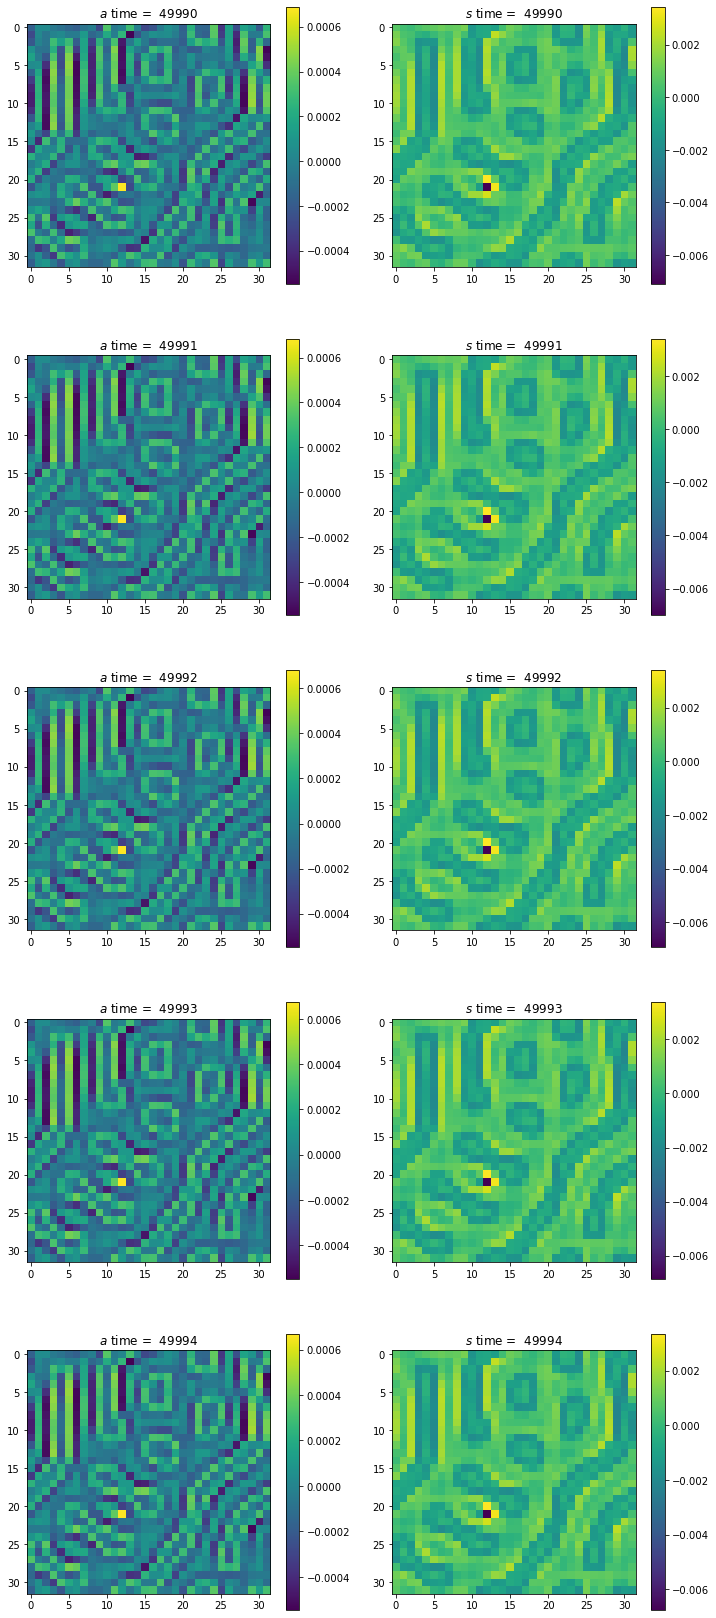

In [128]:



window = -10
_ = plt.figure(figsize=(12,-6*window))
#plt.suptitle("PDE's Residual")
for i in range(0,-window,2):
    plt.subplot(10,2, i+1)
    plt.title(r"$a$" f" time = {int(t[-1])+window+i//2:6d}")
    plt.imshow(residuals[window-i,0, :, :])
    plt.colorbar()
    plt.subplot(10,2, i+2)
    plt.title(r"$s$" f" time = {int(t[-1])+window+i//2:6d}")
    plt.imshow(residuals[window-i,1, :, :])
    plt.colorbar()

plt.show()


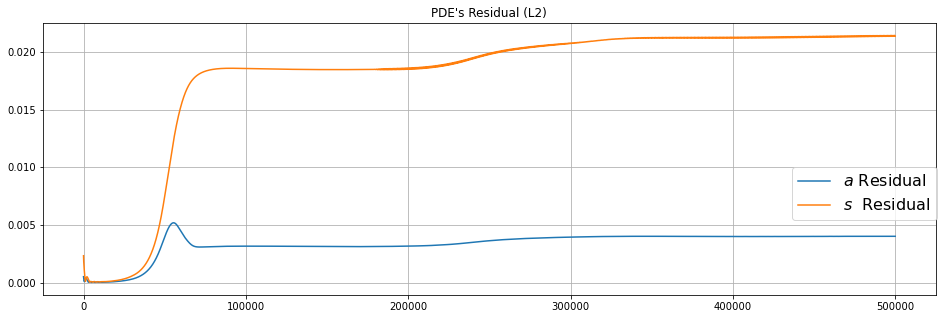

In [129]:
_ = plt.figure(figsize=(16,5))
plt.title("PDE's Residual (L2)")

plt.plot(np.linalg.norm(residuals[:,0, :, :], ord=2, axis=(1,2)), '-', label=r"$a$ Residual" )
plt.plot(np.linalg.norm(residuals[:,1, :, :], ord=2, axis=(1,2)), '-', label=r"$s$  Residual" )
plt.grid()
plt.legend(fontsize=16, bbox_to_anchor=(1.01,.5))

plt.show()


In [130]:
snap_shots = (
      (a_arr[:,:, i+1], s_arr[:,:, i+1], a_arr[:,:, i], s_arr[:,:, i], a_arr[:,:, i-1], s_arr[:,:, i-1])
      for i in range(1, len(t)-1)
)
values = np.array([
    ((a_3-a_1)/2,rhs_a(a_2, s_2, linear=False),
     (s_3-s_1)/2,rhs_s(a_2, s_2, linear=False))
    for a_3, s_3, a_2, s_2, a_1, s_1 in snap_shots
])

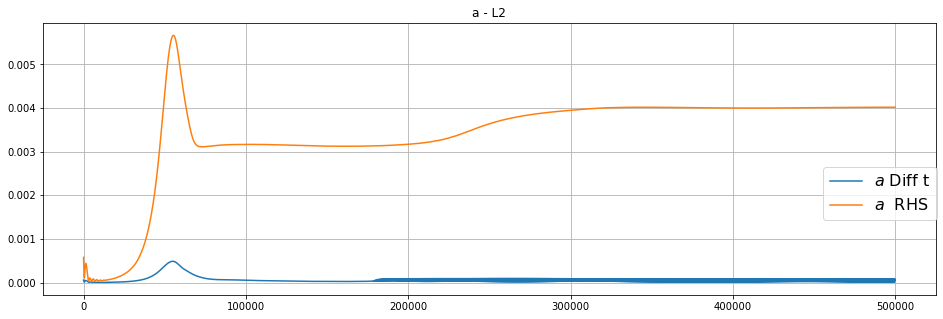

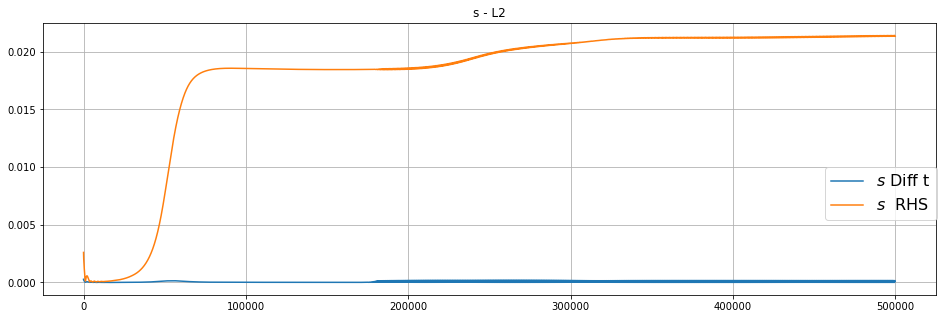

In [131]:
_ = plt.figure(figsize=(16,5))
plt.title("a - L2")

plt.plot(np.linalg.norm(values[:,0, :, :], ord=2, axis=(1,2)), '-', label=r"$a$ Diff t" )
plt.plot(np.linalg.norm(values[:,1, :, :], ord=2, axis=(1,2)), '-', label=r"$a$  RHS" )
plt.grid()
plt.legend(fontsize=16, bbox_to_anchor=(1.01,.5))
#plt.ylim([0,0.01])
plt.show()

_ = plt.figure(figsize=(16,5))
plt.title("s - L2")

plt.plot(np.linalg.norm(values[:,2, :, :], ord=2, axis=(1,2)), '-', label=r"$s$ Diff t" )
plt.plot(np.linalg.norm(values[:,3, :, :], ord=2, axis=(1,2)), '-', label=r"$s$  RHS" )
plt.grid()
plt.legend(fontsize=16, bbox_to_anchor=(1.01,.5))
#plt.ylim([0,0.01])
plt.show()

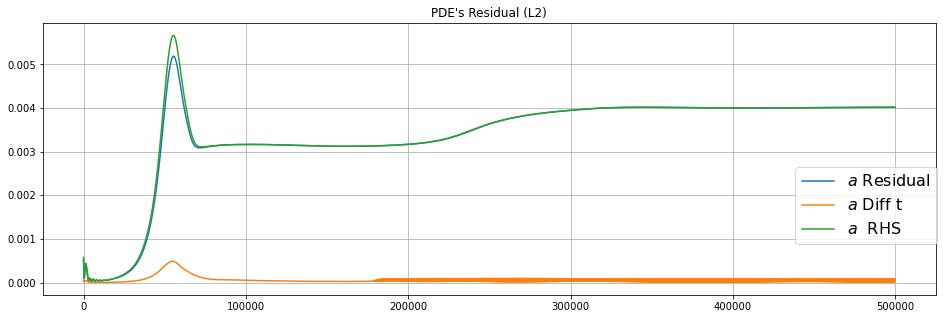

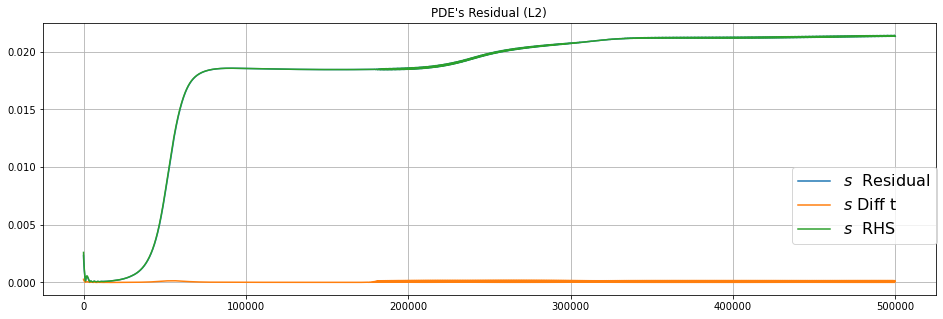

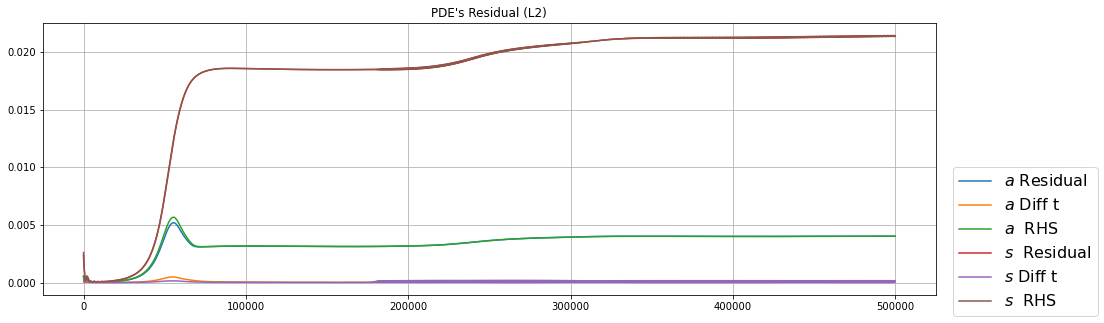

In [132]:
_ = plt.figure(figsize=(16,5))
plt.title("PDE's Residual (L2)")

plt.plot(np.linalg.norm(residuals[:,0, :, :], ord=2, axis=(1,2)), '-', label=r"$a$ Residual" )
plt.plot(np.linalg.norm(values[:,0, :, :], ord=2, axis=(1,2)), '-', label=r"$a$ Diff t" )
plt.plot(np.linalg.norm(values[:,1, :, :], ord=2, axis=(1,2)), '-', label=r"$a$  RHS" )
plt.grid()
plt.legend(fontsize=16, bbox_to_anchor=(1.01,.5))

plt.show()

_ = plt.figure(figsize=(16,5))
plt.title("PDE's Residual (L2)")

plt.plot(np.linalg.norm(residuals[:,1, :, :], ord=2, axis=(1,2)), '-', label=r"$s$  Residual" )
plt.plot(np.linalg.norm(values[:,2, :, :], ord=2, axis=(1,2)), '-', label=r"$s$ Diff t" )
plt.plot(np.linalg.norm(values[:,3, :, :], ord=2, axis=(1,2)), '-', label=r"$s$  RHS" )

plt.grid()
plt.legend(fontsize=16, bbox_to_anchor=(1.01,.5))

plt.show()


_ = plt.figure(figsize=(16,5))
plt.title("PDE's Residual (L2)")

plt.plot(np.linalg.norm(residuals[:,0, :, :], ord=2, axis=(1,2)), '-', label=r"$a$ Residual" )
plt.plot(np.linalg.norm(values[:,0, :, :], ord=2, axis=(1,2)), '-', label=r"$a$ Diff t" )
plt.plot(np.linalg.norm(values[:,1, :, :], ord=2, axis=(1,2)), '-', label=r"$a$  RHS" )

plt.plot(np.linalg.norm(residuals[:,1, :, :], ord=2, axis=(1,2)), '-', label=r"$s$  Residual" )
plt.plot(np.linalg.norm(values[:,2, :, :], ord=2, axis=(1,2)), '-', label=r"$s$ Diff t" )
plt.plot(np.linalg.norm(values[:,3, :, :], ord=2, axis=(1,2)), '-', label=r"$s$  RHS" )
plt.grid()
plt.legend(fontsize=16, bbox_to_anchor=(1.01,.5))

plt.show()

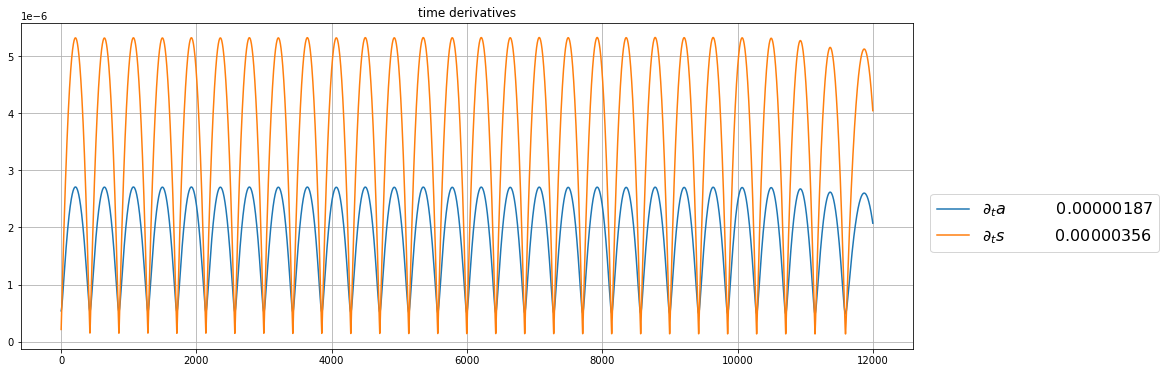

In [137]:
_ = plt.figure(figsize=(16,6))
plt.title("time derivatives")

window = -12000

plt.plot(norms[window:,0], '-', label=r"$\partial_t a$" f"\t\t{np.mean(norms[window:,0]):.8f}")
#plt.plot(norms[window:,2], label=r"rhs $a$"  f"\t      {np.mean(norms[window:,2]):.8f}")

plt.plot(norms[window:,1], '-', label=r"$\partial_t s$" f"\t\t{np.mean(norms[window:,1]):.8f}")
#plt.plot(norms[window:,4], label=r"rhs $s$"  f"\t      {np.mean(norms[window:,4]):.8f}")
#plt.plot(norms[window:,6], label=r"$D_s \nabla^2 s$"  f"\t      {np.mean(norms[window:,6]):.8f}")
#plt.plot(norms[window:,7], label=r"$gg(a,s)$"  f"\t      {np.mean(norms[window:,7]):.8f}")
plt.grid()
plt.legend(fontsize=16, bbox_to_anchor=(1.01,.5))
#plt.xlim([5400, 5500])
#plt.xlim([0, 1000])
#plt.xlim([950, 1000])
#plt.ylim([0,0.01])
#plt.ylim([0,0.002])
plt.show()


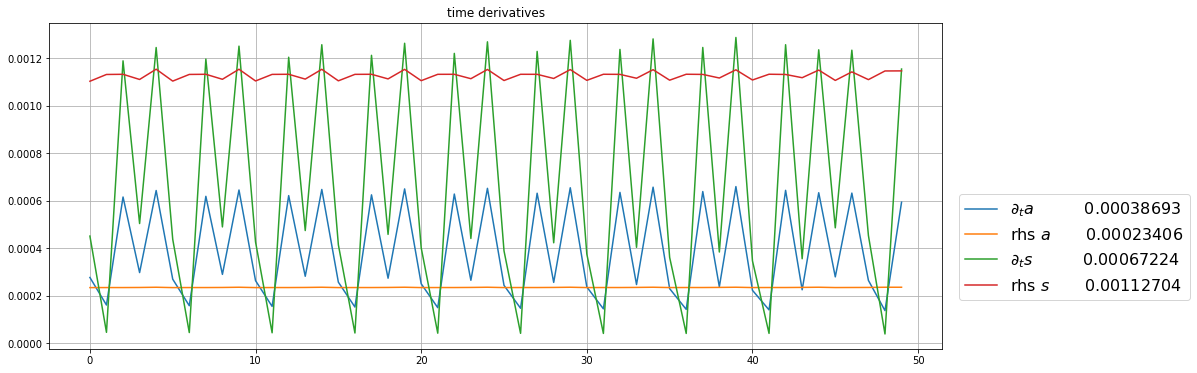

In [22]:
_ = plt.figure(figsize=(16,6))
plt.title("time derivatives")

window = -50

plt.plot(norms[window:,0], '-', label=r"$\partial_t a$" f"\t\t{np.mean(norms[window:,0]):.8f}")
plt.plot(norms[window:,2], label=r"rhs $a$"  f"\t      {np.mean(norms[window:,2]):.8f}")

plt.plot(norms[window:,1], '-', label=r"$\partial_t s$" f"\t\t{np.mean(norms[window:,1]):.8f}")
plt.plot(norms[window:,4], label=r"rhs $s$"  f"\t      {np.mean(norms[window:,4]):.8f}")
#plt.plot(norms[window:,6], label=r"$D_s \nabla^2 s$"  f"\t      {np.mean(norms[window:,6]):.8f}")
#plt.plot(norms[window:,7], label=r"$gg(a,s)$"  f"\t      {np.mean(norms[window:,7]):.8f}")
plt.grid()
plt.legend(fontsize=16, bbox_to_anchor=(1.01,.5))
#plt.xlim([5400, 5500])
#plt.xlim([0, 1000])
#plt.xlim([950, 1000])
#plt.ylim([0,0.01])
#plt.ylim([0,0.002])
plt.show()


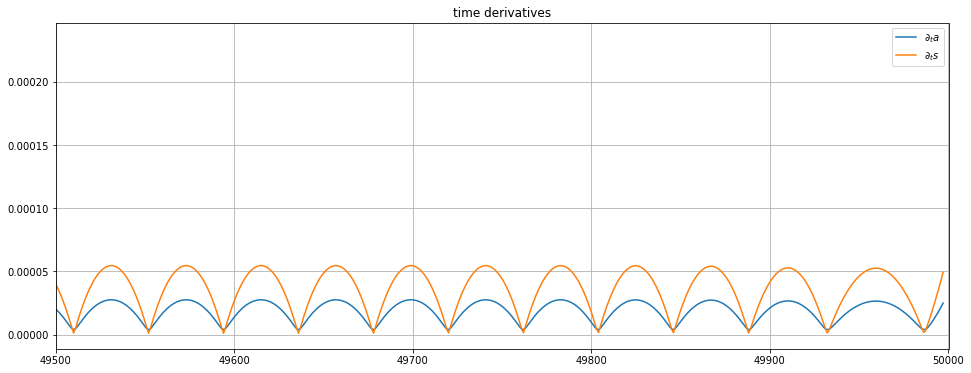

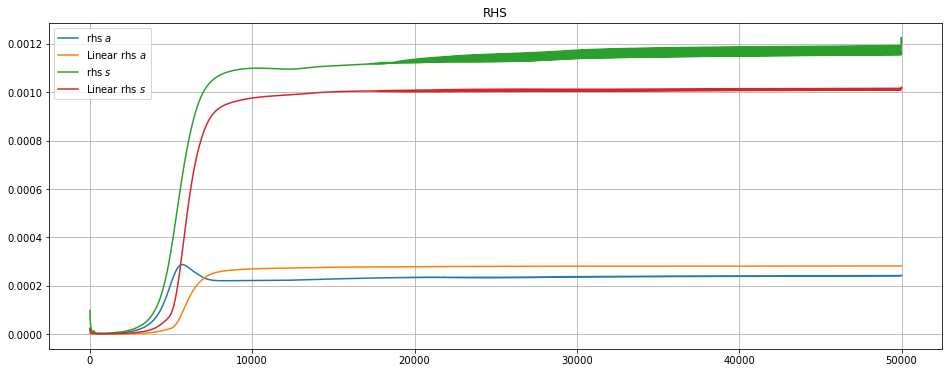

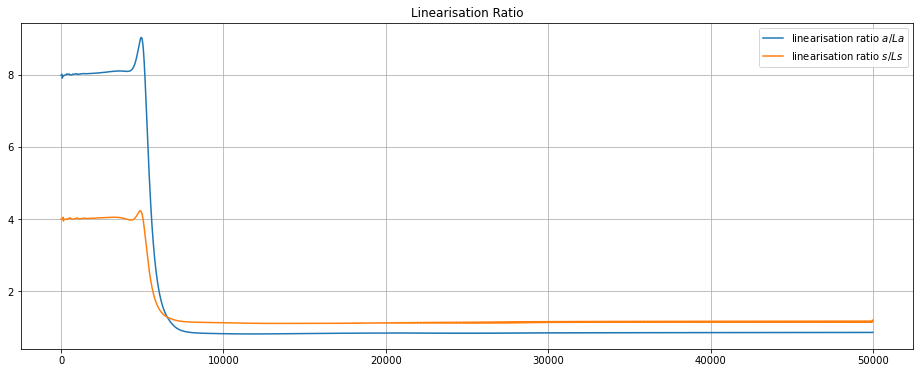

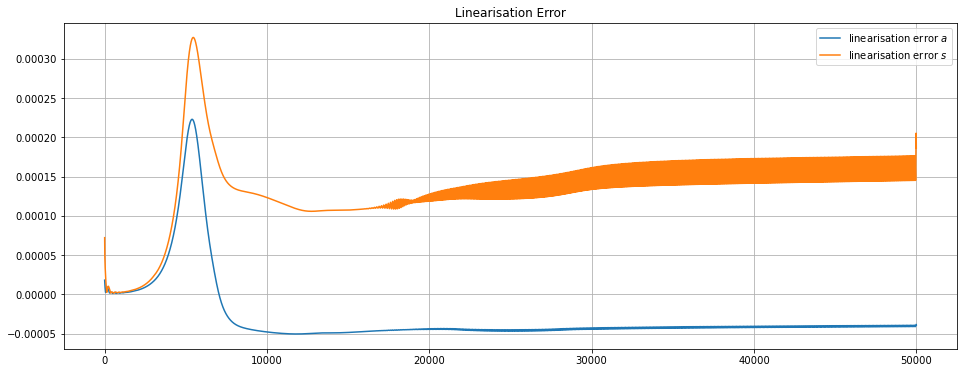

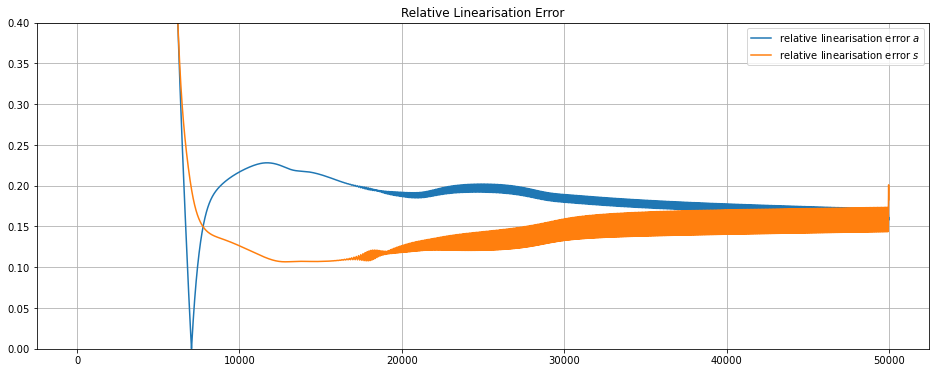

In [43]:
_ = plt.figure(figsize=(16,6))
plt.title("time derivatives")
plt.plot(norms[:,0], label=r"$\partial_t a$")
plt.plot(norms[:,1], label=r"$\partial_t s$")
plt.grid()
plt.legend()
plt.xlim([49500, 50000])
#plt.ylim([0,0.002])
plt.show()

_ = plt.figure(figsize=(16,6))
plt.title("RHS")
plt.plot(norms[:,2], label=r"rhs $a$")
plt.plot(norms[:,3], label=r"Linear rhs $a$")

plt.plot(norms[:,4], label=r"rhs $s$")
plt.plot(norms[:,5], label=r"Linear rhs $s$")
plt.grid()
plt.legend()
#plt.xlim([4000, 6000])
#plt.ylim([0.0022,0.0023])
plt.show()

_ = plt.figure(figsize=(16,6))
plt.title("Linearisation Ratio")
plt.plot(norms[:,2] / norms[:,3], label=r"linearisation ratio $a/ La$")
plt.plot(norms[:,4] / norms[:,5], label=r"linearisation ratio $s/ Ls$")
plt.grid()
plt.legend()
#plt.xlim([4000, 6000])
#plt.ylim([0.0022,0.0023])
plt.show()

_ = plt.figure(figsize=(16,6))
plt.title("Linearisation Error")
plt.plot(norms[:,2] - norms[:,3], label=r"linearisation error $a$")
plt.plot(norms[:,4] - norms[:,5], label=r"linearisation error $s$")
plt.grid()
plt.legend()
#plt.xlim([4000, 6000])
#plt.ylim([0.0022,0.0023])
plt.show()

_ = plt.figure(figsize=(16,6))
plt.title("Relative Linearisation Error")
plt.plot(np.abs(norms[:,2] - norms[:,3])/norms[:,2], label=r"relative linearisation error $a$")
plt.plot(np.abs(norms[:,4] - norms[:,5])/norms[:,5], label=r"relative linearisation error $s$")
plt.grid()
plt.legend()
#plt.xlim([4000, 6000])
plt.ylim([0.0,0.4])
plt.show()